# Analog: Ana(lyzing) Log(s)

I wrote [analog](https://github.com/apparebit/analog) to scratch an itch,
analyzing the access logs for my personal website
[apparebit.com](https://apparebit.com). This notebook chronicles the first
several forays into the data. But the presentation is idealized, since notebook
and analog both changed quite a bit as a result of these forays.

## 1. Preliminaries

We get started by importing analog.

In [1]:
import sys
sys.path.insert(0, '..')

import konsole
konsole.config(level=konsole.DEBUG)

# import analog
import os
import os.path
import sys

import numpy as np
import pandas as pd

# Make package accessible by injecting repository root into Python package path
root, docs = os.path.split(os.getcwd())
assert docs == 'docs' and os.path.basename(root) == 'analog'
sys.path.insert(0, root)
os.chdir(root)

import analog

[INFO] Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[INFO] NumExpr defaulting to 8 threads.
[DEBUG] matplotlib data path: /Users/rgrimm/Work/analog/.venv/lib/python3.11/site-packages/matplotlib/mpl-data.
[DEBUG] CONFIGDIR=/Users/rgrimm/.matplotlib.
[DEBUG] interactive is False.
[DEBUG] platform is darwin.


### 1.1 The Log Data

Next, we load the log data. `analog.latest()` parses, enriches, and combines
monthly logs as needed. `analog.validate()` checks that the dataframe has the
expected columns with the expected types, does not contain null values in
non-null columns, and that columns with correlated null values in fact observe
those correlations.

In [2]:
df = analog.latest(os.path.join(root, 'data'))
df.info(verbose=True, memory_usage=True)
analog.validate(df)

[INFO] Load existing log frame '/Users/rgrimm/Work/analog/data/apparebit.com-2018-07-2023-06.parquet'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310648 entries, 0 to 310647
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   client_address     310648 non-null  string             
 1   timestamp          310648 non-null  datetime64[ns, UTC]
 2   method             310648 non-null  category           
 3   path               310648 non-null  string             
 4   query              5140 non-null    string             
 5   fragment           0 non-null       string             
 6   protocol           310648 non-null  category           
 7   status             310648 non-null  int16              
 8   size               310648 non-null  int32              
 9   referrer           135151 non-null  string             
 10  user_agent         306800 non-null  string             
 11  server_name        285613 non-null  string             
 12  server_address     285613 non-

The 36 columns listed above comprise three kinds of data:

  * `client_address` through `server_address` are parsed from access log;
  * `content_type` through `status_class` are derived from primary data;
  * `client_name` through `is_bot2` are extracted from databases.

### 1.2 Two Sources of Truth for Bots

Analog uses two different projects' regular expressions for classifying user
agents as bots:

 1. `agent_family` through `is_bot` are filled in with
    [ua-parser](https://github.com/ua-parser).
 2. `bot_category` and `is_bot2` are filled in with
    [matomo](https://github.com/matomo-org/device-detector).
    
We need both:

In [3]:
def requests_per_agent(label, data):
    with analog.fresh_counts() as rows:
        data.count_rows().unique_values('user_agent').count_rows()
        print(f'{label:<20}: {rows[0]:7,} requests from {rows[1]:5,} user agents')

log = analog.analyze(df)
requests_per_agent('all requests', log)
requests_per_agent('ua-parser or matomo', log.only.bots())
requests_per_agent('ua-parser only', log.only.equals('is_bot1', True))
requests_per_agent('matomo only', log.only.equals('is_bot2', True))

all requests        : 310,648 requests from 8,866 user agents
ua-parser or matomo : 108,036 requests from 3,341 user agents
ua-parser only      :  89,163 requests from   538 user agents
matomo only         :  87,738 requests from 3,261 user agents


A more detailed comparison of the two classifications revealed a minor bug in
`ua-parser`'s classification. Analog corrects that bug while enriching the
parsed access logs.

## 2. Page Views

[apparebit.com](https://apparebit.com) utilizes commercially licensed fonts. The
license terms impose an upper limit of monthly page views. Hence, I'm eager to
check them first:

In [4]:
page_views = (
    analog.analyze(df)  # A page view
    .only.successful()  # is a successful
    .only.GET()         # GET request
    .only.markup()      # for markup (HTML)
    .only.humans()      # made by humans.
)

### 2.1 Monthly Page Views

So how many page views were there for each month? Not enough to require purchase
of the next license tier. Yay!

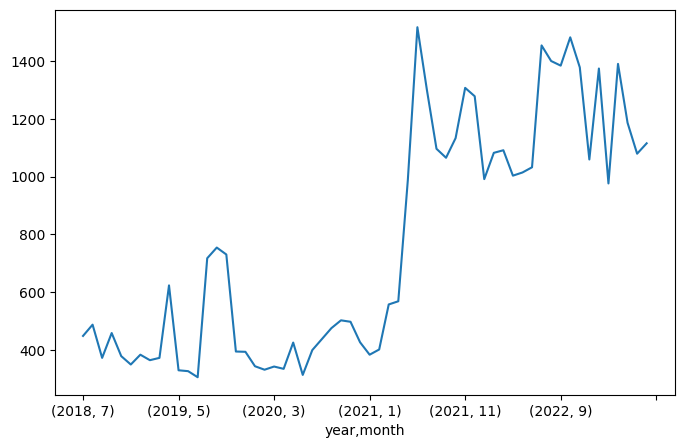

In [5]:
konsole.config(level=konsole.INFO) # Unless you want to wade through hundreds of findfont log entries...
page_views.monthly.requests().plot(figsize=(8,5)).done()

### 2.2 Top 10 Most Popular Pages Last Month

Ooh, I love how traffic increased in early 2021. But what pages drew the most
visitors? Let's check the top 10 most popular pages for the last month:

In [6]:
page_views.over.last_month().value_counts("cool_path").show(rows=10).done()

,count
cool_path,
/,442
/blog/2019/i-feel-love,268
/blog/2022/wrong-impression,107
/blog,33
/about/apparebit,25
/features/breath,22
/about/privacy,21
/features/candy-or-bust/voyeur,21
/about/robert-grimm,20


### 2.3 Top 10 Most Popular Pages Last Year

Hmm, interesting. What were the 10 most popular pages for the last year?

In [7]:
page_views.over.last_year().value_counts("cool_path").show(rows=10).done()

,count
cool_path,
/,3018
/blog/2019/i-feel-love,1332
/blog/2022/wrong-impression,733
/blog,244
/about/apparebit,213
/about/robert-grimm,171
/about/privacy,141
/about/robert-grimm/with-halo,100
/features/candy-or-bust/voyeur,96


### 2.4 Domain Names for the Win!

It sure makes sense that my home page is #1. I also expected the blog index to
be popular. But I didn't expect the blog posts [Game of Thrones, US
Edition](https://apparebit.com/blog/2021/game-of-thrones) and [I Feel
Love](https://apparebit.com/blog/2019/i-feel-love) to be that popular.

Come to think of it, the two pages do share one trait that separates them from
all other posts: I own two other domains, [deface.info](http://deface.info) and
[obscenely.gay](http://obscenely.gay), that just happen to redirect to them. At
the same time, I haven't advertised the two secondary domains beyond mentioning
them on Twitter. So do these secondary domains make a difference?

The thing is: It's pretty much impossible to prove or disprove whether the
secondary domains boost traffic based on the log data. In theory, the `Referer`
(sic) header would provide us with just the information we need. But in
practice, the two domain registrars providing URL forwarding for the domains
(understandably) do not go through the trouble of maintaining TLS certificates
for them. As a result, a browser accessing either domain necessarily starts out
using insecure HTTP and, since <apparebit.com> only supports HTTPS, ends up with
secure HTTPS. But according to the latest default referrer policy,
`strict-origin-when-cross-origin`, clients should *not* include the `Referer`
for requests with no or mixed security.

Let's check the data for *I Feel Love*:

In [8]:
def domain_to_path(data, domain, path):
    with analog.fresh_counts() as counts:
        referrers = (
            data
            .only.equals('cool_path', path)
            .over.last_year()
            .count_rows()
            .value_counts('referrer_host')
            .show()
            .data
        )

    requests = pd.Series([
        counts[0] - referrers.sum(), # No referrer
        referrers.get('www.google.com', 0),
        referrers.get(domain, 0) + referrers.get(f'www.{domain}', 0),
        counts[0]
    ], ['no_referrer', 'google', domain, 'page_views']).rename('requests')
    percentages = (requests * 100 / counts[0]).round(1).rename('percent')
    return analog.merge(requests, percentages)

domain_to_path(page_views, 'obscenely.gay', '/blog/2019/i-feel-love')

,count
referrer_host,
obscenely.gay,436
www.google.com,77
www.obscenely.gay,73
obscenely.gay:80,19
obscenely.gay:443,17
apparebit.com,15
blog.obscenely.gay,13
obscenely.gay.,11
wordpress.obscenely.gay,6


,requests,percent
no_referrer,641,48.1
google,77,5.8
obscenely.gay,509,38.2
page_views,1332,100.0


Just as predicted, a large number of requests, 50.4%, do not include a referrer,
while only small number, 8.1%, can be attributed to `obscenely.gay`. At 36.8% of
all requests, Google turns out to be an important source of traffic — for this
page.

Two comments about the code above:

  1. Analog augments but not replaces Pandas. More complicated analysis, like
     the one above, may just require falling back onto Pandas.
  2. It often pays off to define a function when performing non-trivial
     analysis. Chances are we'll be able to reuse it.
     
In fact, let's reuse the above function right now:

In [9]:
domain_to_path(page_views, 'deface.info', '/blog/2022/wrong-impression')

,count
referrer_host,
deface.info,165
www.deface.info,38
apparebit.com,35
www.google.com,25
l.facebook.com,4
m.facebook.com,3
baidu.com,3
t.co,3
google.com,2


,requests,percent
no_referrer,453,61.8
google,25,3.4
deface.info,203,27.7
page_views,733,100.0


At 69.1%, the lack of referrers is even more pronounced for *Game of Thrones, US
Edition*, whereas the percentage of referrals from the secondary domain is
almost double, though still quite small.

#### Lesson Learned

While I cannot prove that the secondary domains serve as traffic boosters, that
still seems like the simplest explanation. Hence, I'm inclined to believe it
anyways. That belief then leads me to the following rule for maximizing the
domains' impact:

> Make sure to point `obscenely.gay` at my gayest page and `deface.info` at the
> page that is most damning for Facebook!

As of this writing, the latter is [Wrong
Impression](https://apparebit.com/blog/2022/wrong-impression), which presents
compelling evidence that Facebook is cooking the books and hence misrepresenting
its business to paying customers, investors, and regulators alike. I've updated
`deface.info` accordingly.

## 3. Status Codes

Let switch gears a bit: So far, we considered only successful GET requests for
markup by humans, i.e., page views. Now, we are going to consider all requests
and the resulting response status codes.


### 3.1 The Four Status Classes

HTTP status codes come in hundreds and distinguish between:

  * 2xx: successful requests,
  * 3xx: redirections,
  * 4xx: client errors,
  * 5xx: server errors.

Let's look at these four status classes on a monthly basis:

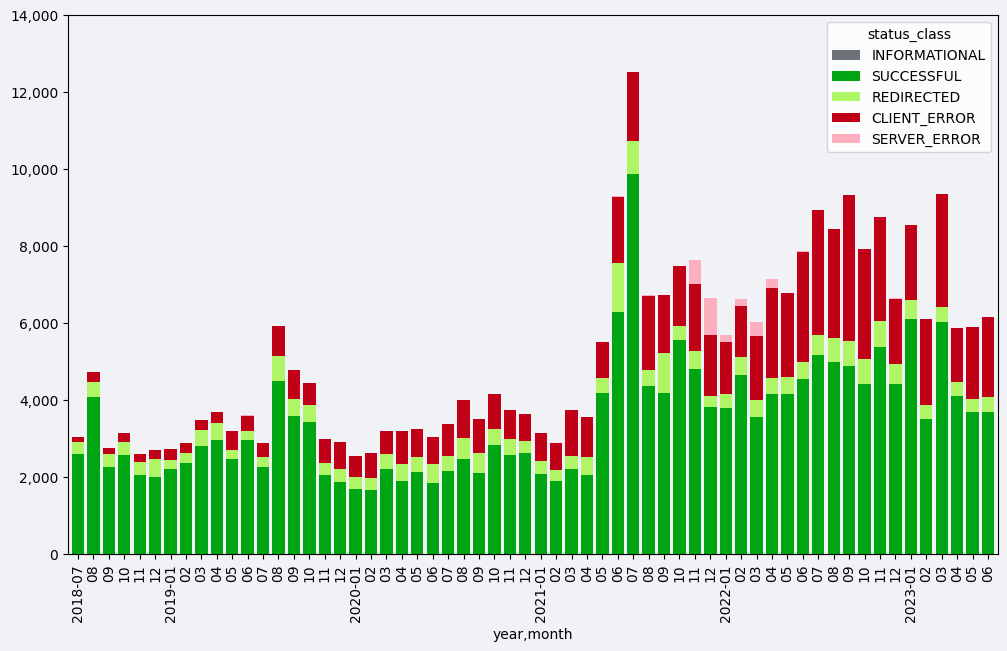

In [10]:
request_status = (
    analog.analyze(df)
    .monthly.status_classes()
    .plot(kind='bar', stacked=True, width=0.8, figsize=(12,7), color=[
        '#6d7278', '#00a513', '#b0f566', '#bf0016', '#fdafc0'
    ])
)

data = request_status.data
axes = request_status.axes
figure = axes.get_figure()

figure.set_facecolor('#f0f2f5')
axes.set_facecolor('#f0f2f5')

yticks = axes.get_yticks().tolist()
# Next line silences warning (https://stackoverflow.com/questions/63723514
# /userwarning-fixedformatter-should-only-be-used-together-with-fixedlocator)
axes.yaxis.set_ticks(yticks)
axes.yaxis.set_ticklabels(['{:,}'.format(int(x)) for x in yticks])

def year_month_labels(year_months, axes):
    labels = []
    current_year = None
    for year, month in year_months:
        labels.append(f'{year}-{month:02}' if year != current_year else f'{month:02}')
        current_year = year
    axes.set_xticks([*range(len(year_months))])
    axes.set_xticklabels(labels, rotation=90)

year_month_labels(data.index.tolist(), axes)

Sweet! That's a nice graph. Admittedly, it took some futzing with plot size and
column `width` because the defaults made for too small a graph with too much
space between columns. But adjusting the plot was easy, since analog passes
keyword arguments through to Pandas' `plot()` method.

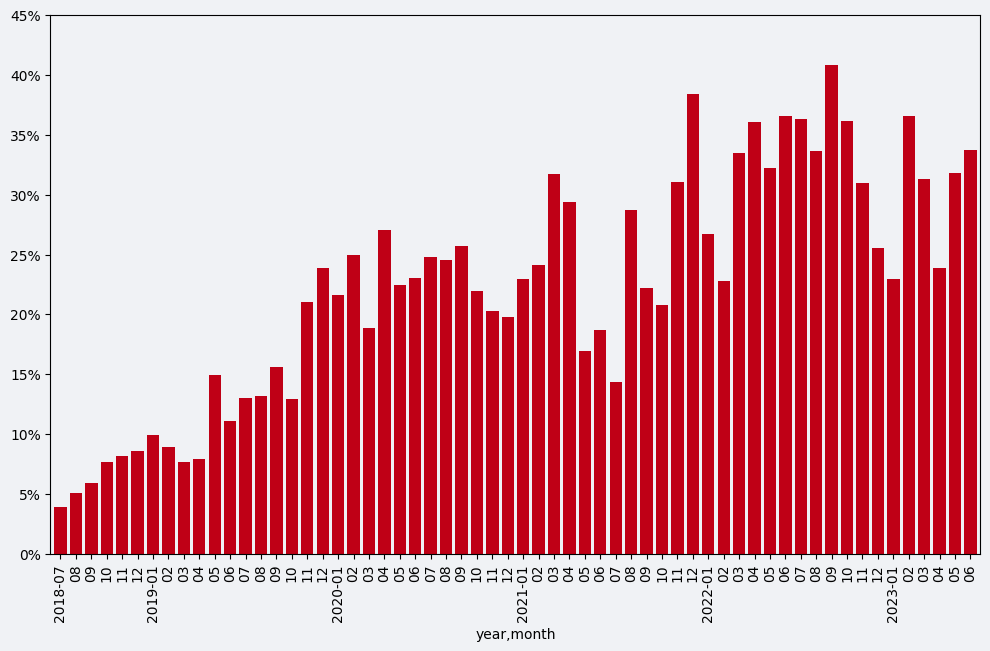

In [11]:
error_percent = (data['CLIENT_ERROR'] + data['SERVER_ERROR']) / data.sum(axis=1) * 100
axes = error_percent.plot(kind='bar', width=0.8, figsize=(12,7), color=['#bf0016'])
figure = axes.get_figure()

figure.set_facecolor('#f0f2f5')
axes.set_facecolor('#f0f2f5')

yticks = axes.get_yticks().tolist()
# Next line silences warning (https://stackoverflow.com/questions/63723514
# /userwarning-fixedformatter-should-only-be-used-together-with-fixedlocator)
axes.yaxis.set_ticks(yticks)
axes.yaxis.set_ticklabels([f'{x:.0f}%' for x in yticks])


year_month_labels(error_percent.index, axes)


### 3.2 Top 10 Paths Resulting in Server Errors

The presence of server errors is a bit surprising. It suggests that my hosting
provider's shared server instance isn't particularly well managed, at least from
June 2021 through June 2022. That's no good. But before calling their customer
service, we should find out a little more about those server errors:

In [12]:
(
    analog.analyze(df)
    .over.range(*analog.monthly_period('2021-06', '2022-06'))
    .only.server_error()
    .value_counts('path')
    [:10]
)

,count
path,
/blog/2021/game-of-thrones/wp1/wp-includes/wlw...,156
/blog/2021/game-of-thrones/wp/wp-includes/wlwm...,156
/blog/2021/game-of-thrones/wordpress/wp-includ...,156
/blog/2021/game-of-thrones/web/wp-includes/wlw...,156
/blog/2021/game-of-thrones/cms/wp-includes/wlw...,156
/blog/2021/game-of-thrones/test/wp-includes/wl...,156
/blog/2021/game-of-thrones/site/wp-includes/wl...,156
/blog/2021/game-of-thrones/blog/wp-includes/wl...,151
/blog/2021/game-of-thrones/shop/wp-includes/wl...,149


Ah, WordPress! I'm guessing that the shared server is somehow misconfigured and
fails on these probes for WordPress security vulnerabilities. Personally, I'm
glad I'm not using a content management system, but instead rely on [my own
static website generator](https://github.com/apparebit/siteforge) instead.

**About HTML tables**: The code cell above chops off rows beyond the 10th one
but does not print the wrapped series — instead letting the wrapped series
become the cell's value. Since all fluent wrappers implement the `_repr_html_()`
method, IPython automatically formats the data with that method. In contrast,
analog's fluent `.print()` method needs to work a tad harder to also emit an
HTML table when inside IPython. In fact, if you go back to the referrer counts,
you'll find that the same cell prints one dataframe and finishes with another
dataframe.

### 3.3 Analysis of Client Errors

While we are at it, let's look at client errors, too:

In [13]:
from IPython.display import display, HTML
from analog.ipaddr import resolve_to_countries

client_errors = analog.analyze(df).over.last_year().only.client_error()

display(HTML('<strong>Breakdown by status code</strong>'))
display(client_errors.value_counts('status'))

display(HTML('<strong>Breakdown by path (top 20)</strong>'))
display(client_errors.value_counts('path')[:20])

display(HTML('<strong>Breakdown by client_address (top 20)</strong>'))
addresses = client_errors.value_counts('client_address')[:20].data
localized_addresses = (
    pd.DataFrame(
        resolve_to_countries(addresses.index),
        columns=['client_address', 'country'],
    )
    .join(addresses, on='client_address', how='inner')
)
display(localized_addresses)

display(HTML('<strong>First 20 client errors for Home Page</strong>'))
display(client_errors.only.equals('path', '/')[:20])

display(HTML('<strong>First 20 client errors for I Feel Love</strong>'))
display(client_errors.only.equals('path', '/blog/2019/i-feel-love')[:20])

display(HTML('<strong>First 20 client errors for Bely Display</strong>'))
display(client_errors.only.equals('path', '/assets/fonts/bely-display.woff2')[:20])

display(HTML('<strong>First 20 client errors for non-existent ads.txt</strong>'))
display(client_errors.only.equals('path', '/ads.txt')[:20])


,count
status,
404,6624
406,4381
403,1068
409,373
421,19
405,2


,count
path,
/blog/2019/i-feel-love,452
/favicon.ico,392
/ads.txt,350
/,287
/assets/fonts/bely-regular.woff2,227
/wp-login.php,200
/th1s_1s_a_4o4.html,181
/robots.txt,180
/e/data/js/ajax.js,164


,client_address,country,count
0,178.62.2.74,United Kingdom of Great Britain and Northern I...,232
1,163.172.255.57,France,223
2,217.182.193.103,France,222
3,45.141.215.69,Poland,210
4,162.55.86.62,Germany,180
5,198.20.67.200,United States of America,170
6,184.154.76.34,United States of America,155
7,138.199.60.187,Singapore,138
8,31.220.1.7,Germany,124
9,20.125.148.84,United States of America,105


,client_address,timestamp,method,path,query,fragment,protocol,status,size,referrer,...,client_country,agent_family,agent_version,os_family,os_version,device_family,device_brand,device_model,is_bot1,is_bot2
268755,114.119.133.120,2023-01-01 07:41:03+00:00,GET,/,<NA>,<NA>,1.1,406,226,https://wiki.jacob.chvatal.com/pages/ricing,...,SG,PetalBot,,Other,,Spider,Spider,Smartphone,True,True
268774,162.55.86.62,2023-01-01 10:52:39+00:00,GET,/,<NA>,<NA>,1.1,406,226,<NA>,...,DE,BLEXBot,1.0,Other,,Spider,Spider,Desktop,True,True
268844,162.55.86.62,2023-01-01 22:44:13+00:00,GET,/,<NA>,<NA>,1.1,406,226,<NA>,...,DE,BLEXBot,1.0,Other,,Spider,Spider,Desktop,True,True
269035,165.22.199.14,2023-01-02 18:02:44+00:00,GET,/,<NA>,<NA>,2.0,406,226,<NA>,...,NL,AhrefsBot,7.0,Other,,Spider,Spider,Desktop,True,True
269217,162.55.86.62,2023-01-03 19:35:37+00:00,GET,/,<NA>,<NA>,1.1,406,226,<NA>,...,DE,BLEXBot,1.0,Other,,Spider,Spider,Desktop,True,True
270162,114.119.138.207,2023-01-06 18:08:43+00:00,GET,/,<NA>,<NA>,1.1,406,226,https://131.180.119.44/profile/iwaco-2020/robe...,...,SG,PetalBot,,Other,,Spider,Spider,Smartphone,True,True
270400,162.55.86.62,2023-01-08 00:45:40+00:00,GET,/,<NA>,<NA>,1.1,406,226,<NA>,...,DE,BLEXBot,1.0,Other,,Spider,Spider,Desktop,True,True
270623,162.243.185.35,2023-01-09 01:05:51+00:00,GET,/,<NA>,<NA>,1.0,406,226,<NA>,...,US,Other,,Other,,Other,,,False,True
273233,35.205.96.143,2023-01-13 19:14:49+00:00,GET,/,<NA>,<NA>,1.1,406,226,<NA>,...,BE,Python Requests,2.28,Other,,Other,,,False,False
273234,35.205.96.143,2023-01-13 19:14:49+00:00,GET,/,<NA>,<NA>,1.1,406,226,<NA>,...,BE,Python Requests,2.28,Other,,Other,,,False,False


,client_address,timestamp,method,path,query,fragment,protocol,status,size,referrer,...,client_country,agent_family,agent_version,os_family,os_version,device_family,device_brand,device_model,is_bot1,is_bot2
268926,114.119.145.216,2023-01-02 08:34:10+00:00,GET,/blog/2019/i-feel-love,<NA>,<NA>,1.1,406,226,<NA>,...,SG,PetalBot,,Other,,Spider,Spider,Smartphone,True,True
269206,54.36.148.127,2023-01-03 15:35:51+00:00,GET,/blog/2019/i-feel-love,<NA>,<NA>,2.0,406,226,<NA>,...,FR,AhrefsBot,7.0,Other,,Spider,Spider,Desktop,True,True
269224,54.36.148.124,2023-01-03 22:12:06+00:00,GET,/blog/2019/i-feel-love,<NA>,<NA>,2.0,406,226,<NA>,...,FR,AhrefsBot,7.0,Other,,Spider,Spider,Desktop,True,True
269407,54.36.149.14,2023-01-04 07:32:36+00:00,GET,/blog/2019/i-feel-love,<NA>,<NA>,2.0,406,226,<NA>,...,FR,AhrefsBot,7.0,Other,,Spider,Spider,Desktop,True,True
270427,77.75.79.31,2023-01-08 07:43:56+00:00,GET,/blog/2019/i-feel-love,<NA>,<NA>,1.1,406,226,<NA>,...,CZ,SeznamBot,4.0,Other,,Spider,Spider,Desktop,True,True
271459,114.119.167.239,2023-01-10 08:16:32+00:00,GET,/blog/2019/i-feel-love,<NA>,<NA>,1.1,406,226,<NA>,...,SG,PetalBot,,Other,,Spider,Spider,Smartphone,True,True
273764,87.236.176.220,2023-01-16 18:35:06+00:00,GET,/blog/2019/i-feel-love,<NA>,<NA>,1.1,421,322,http://obscenely.gay,...,GB,Other,,Other,,Other,,,False,True
274328,114.119.155.54,2023-01-18 01:49:06+00:00,GET,/blog/2019/i-feel-love,<NA>,<NA>,1.1,406,226,<NA>,...,SG,PetalBot,,Other,,Spider,Spider,Smartphone,True,True
274369,159.223.50.5,2023-01-18 09:55:57+00:00,GET,/blog/2019/i-feel-love,<NA>,<NA>,1.1,406,226,<NA>,...,SG,Python Requests,2.27,Other,,Other,,,False,False
274370,159.223.50.5,2023-01-18 09:55:58+00:00,GET,/blog/2019/i-feel-love,<NA>,<NA>,1.1,406,226,<NA>,...,SG,Python Requests,2.27,Other,,Other,,,False,False


,client_address,timestamp,method,path,query,fragment,protocol,status,size,referrer,...,client_country,agent_family,agent_version,os_family,os_version,device_family,device_brand,device_model,is_bot1,is_bot2
268761,198.20.67.200,2023-01-01 10:49:47+00:00,GET,/assets/fonts/bely-display.woff2,<NA>,<NA>,1.1,403,4545,<NA>,...,US,SiteLockSpider,,Windows,NT,Spider,Spider,Desktop,True,False
269142,40.77.167.78,2023-01-03 09:58:27+00:00,GET,/assets/fonts/bely-display.woff2,<NA>,<NA>,2.0,403,1898,<NA>,...,US,bingbot,2.0,Other,,Spider,Spider,Desktop,True,True
269163,184.154.76.34,2023-01-03 10:49:03+00:00,GET,/assets/fonts/bely-display.woff2,<NA>,<NA>,1.1,403,4545,http://www.google.com/url?url=apparebit.com&ya...,...,US,IE,10.0,Windows,7,Other,,,False,False
269593,198.20.67.200,2023-01-05 02:27:43+00:00,GET,/assets/fonts/bely-display.woff2,<NA>,<NA>,1.1,403,4545,http://www.google.com/url?url=apparebit.com&ya...,...,US,IE,10.0,Windows,7,Other,,,False,False
269746,184.154.139.8,2023-01-05 10:46:18+00:00,GET,/assets/fonts/bely-display.woff2,<NA>,<NA>,1.1,403,4545,<NA>,...,US,SiteLockSpider,,Windows,NT,Spider,Spider,Desktop,True,False
270262,184.154.76.34,2023-01-07 10:47:23+00:00,GET,/assets/fonts/bely-display.woff2,<NA>,<NA>,1.1,403,4545,http://www.google.com/url?url=apparebit.com&ya...,...,US,IE,10.0,Windows,7,Other,,,False,False
270445,184.154.139.8,2023-01-08 10:46:02+00:00,GET,/assets/fonts/bely-display.woff2,<NA>,<NA>,1.1,403,4545,http://www.google.com/url?url=apparebit.com&ya...,...,US,IE,10.0,Windows,7,Other,,,False,False
270852,198.20.67.200,2023-01-09 10:48:17+00:00,GET,/assets/fonts/bely-display.woff2,<NA>,<NA>,1.1,403,4545,http://www.google.com/url?url=apparebit.com&ya...,...,US,IE,10.0,Windows,7,Other,,,False,False
271675,207.46.13.19,2023-01-11 03:08:13+00:00,GET,/assets/fonts/bely-display.woff2,<NA>,<NA>,2.0,403,1898,<NA>,...,US,bingbot,2.0,Other,,Spider,Spider,Desktop,True,True
271704,184.154.76.34,2023-01-11 10:53:53+00:00,GET,/assets/fonts/bely-display.woff2,<NA>,<NA>,1.1,403,4545,<NA>,...,US,SiteLockSpider,,Windows,NT,Spider,Spider,Desktop,True,False


,client_address,timestamp,method,path,query,fragment,protocol,status,size,referrer,...,client_country,agent_family,agent_version,os_family,os_version,device_family,device_brand,device_model,is_bot1,is_bot2
269413,34.133.88.216,2023-01-04 11:54:39+00:00,GET,/ads.txt,<NA>,<NA>,1.1,404,1902,<NA>,...,US,PhantomBot,1.0,Other,,Spider,Spider,Desktop,True,False
269484,23.229.104.2,2023-01-04 16:37:48+00:00,GET,/ads.txt,<NA>,<NA>,1.1,404,1902,<NA>,...,US,Chrome,108.0.0,Windows,10,Other,,,False,False
269525,157.245.0.205,2023-01-04 23:00:54+00:00,GET,/ads.txt,<NA>,<NA>,2.0,404,1902,https://www.apparebit.com/ads.txt,...,US,Chrome,85.0.4183,Windows,10,Other,,,False,False
269526,157.245.0.205,2023-01-04 23:00:54+00:00,GET,/ads.txt,<NA>,<NA>,2.0,404,1902,<NA>,...,US,Chrome,85.0.4183,Windows,10,Other,,,False,False
269527,157.245.0.205,2023-01-04 23:00:54+00:00,GET,/ads.txt,<NA>,<NA>,2.0,404,1902,http://apparebit.com/ads.txt,...,US,Chrome,85.0.4183,Windows,10,Other,,,False,False
269529,157.245.0.205,2023-01-04 23:00:55+00:00,GET,/ads.txt,<NA>,<NA>,2.0,404,1902,https://www.apparebit.com/ads.txt,...,US,Chrome,85.0.4183,Windows,10,Other,,,False,False
269531,157.245.0.205,2023-01-04 23:00:56+00:00,GET,/ads.txt,<NA>,<NA>,2.0,404,1902,https://www.apparebit.com/ads.txt,...,US,Chrome,85.0.4183,Windows,10,Other,,,False,False
269532,157.245.0.205,2023-01-04 23:00:56+00:00,GET,/ads.txt,<NA>,<NA>,2.0,404,1902,<NA>,...,US,Chrome,85.0.4183,Windows,10,Other,,,False,False
269533,157.245.0.205,2023-01-04 23:00:57+00:00,GET,/ads.txt,<NA>,<NA>,2.0,404,1902,http://apparebit.com/ads.txt,...,US,Chrome,85.0.4183,Windows,10,Other,,,False,False
269535,157.245.0.205,2023-01-04 23:00:57+00:00,GET,/ads.txt,<NA>,<NA>,2.0,404,1902,https://www.apparebit.com/ads.txt,...,US,Chrome,85.0.4183,Windows,10,Other,,,False,False


Different paths are clearly associated with different user errors. Trying to
access a non-existent page results in 404 NOT FOUND. But trying to access a font
without the right headers results in 403 FORBIDDEN. The home page and "I Feel
Love" see a lot of 406 NOT ACCEPTABLE errors. Since they all are caused by bots
and scripts, it seems that people use very restrictive accept headers.